In this notebook, we view the UMAP projection and look at the distribution of segment hand labels across clusters. There are two classes with much smaller counts and these appear to fit into other larger segment classes. 

# View UMAP Projection

In [1]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos"

In [6]:
DT_ID = '2022-03-04_18-41-29'

In [7]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_umap.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,indvi,filename,group,location,sex,wav_loc,key,rate,specs,umap
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]"
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]"
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]"


## View projection

In [8]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [9]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [10]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/1333 [00:00<?, ?it/s]

(1333, 4096)

In [11]:
from avgn.visualization.projections import scatter_spec

In [ ]:
nex = -1

color = ["black", "midnightblue", "tab:blue", "cornflowerblue", "powderblue", "lavender"]

scatter_spec(
    np.array(list(seg_df['umap'].values)),
    specs,
    column_size=12,
    x_range = [-2,15.25],
    y_range = [-4.5,12.75],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.labels.values,
        'alpha':1,
        's': 5,
        'show_legend': True,
        "color_palette": color,
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':0.4,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);
save_loc = (FIGURE_DIR / DATASET_ID / 'Figures' / 'FigS2.jpeg')
ensure_dir(save_loc.as_posix())
save_fig(save_loc, dpi=600, save_jpg=True)
plt.show()

With some scattered exceptions, it appears that most data within the four larger segment classes fit into their own clusters. However, the two smaller segment classes (HL & US) largely cluster within other larger segment classes. In the next step, we'll have a closer look into this using silhouette score.

## Silhouette score
This is compares the UMAP projection with the original hand labels.

In [13]:
from avgn.clusterability.silhouette import nn, sil, plot_within_without

In [14]:
# labels
labels = seg_df['labels']

In [15]:
embedding = np.asarray(list(seg_df['umap'])) # UMAP coordinates

### Calculate nearest neighbour stats

In [16]:
knn=5 #  for knn=5 nearest neighbors

nn_stats = nn(embedding, np.asarray(labels), k=knn)

In [17]:
# Summary scores
print("Evaluation score S (unweighted average of same-class probability P for all classes):",round(nn_stats.get_S(),3))
print("Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes)::",round(nn_stats.get_Snorm(),3))

Evaluation score S (unweighted average of same-class probability P for all classes): 80.417
Evaluation score Snorm (unweighted average of normalized same-class probability Pnorm for all classes):: 3.326


In [18]:
import seaborn as sns

### Plot nearest neighbour metrics

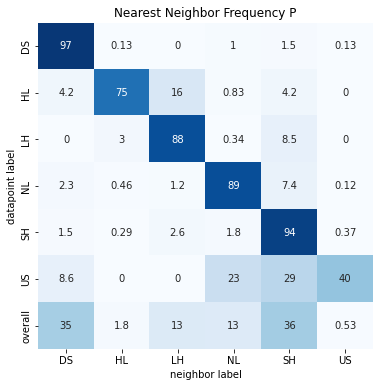

In [19]:
nn_stats.plot_heat_S(vmin=0,       # lower end (for color scheme)
                     vmax=100,     # upper end (for color scheme)
                     center=50,    # center(for color scheme)
                     cmap=sns.color_palette("Blues", as_cmap=True),# color scheme 
                     cbar=None,    # show colorbar if True else don't
                     outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

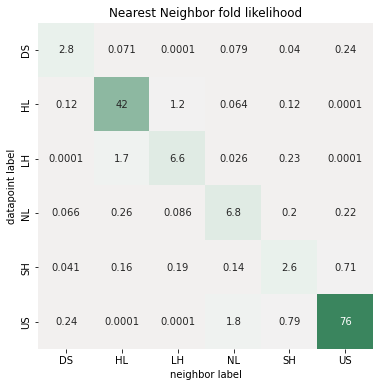

In [20]:
nn_stats.plot_heat_fold(center=1,    # center(for color scheme)
                        cmap=sns.diverging_palette(20, 145, as_cmap=True),# color scheme 
                        cbar=None,    # show colorbar if True else don't
                        outname=None) # filename (with path) where figure will be saved. Default: None -> figure not saved

In [21]:
#Silhouette Avrg Score
labelscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.labels.values)
labelscore

0.21351023

In [22]:
##K-W H test
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.labels.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.labels.values))

In [23]:
KWlabels = kruskal(samples, chance_samples)
KWlabels

KruskalResult(statistic=748.7864371365849, pvalue=7.366719210428952e-165)

Judging from these results, it appears that HL does indeed belong to the LH segment class, however it is not clear for US which is most closely likely to be closer to either NL or SH. As such, we will run another UMAP just on these three segment classes (NL, SH, US) to check this (next notebook). 